# MSE Breakdown
This looks at how the lapse rate and free troposphere temperature gradient cause $h(x)$ to differ from $\overline{h}$

In [2]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.convection import lapse_moist, equivalent_potential_temp
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import L_v, c_p, R, radius_earth, rot_earth, g
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.calculus import grad_x, grad_y
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-03-25 15:27:37,954 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'ucomp', 'height', 'vcomp', 'ps', 'sphum']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# exp_dir = 'tau_sweep/aquaplanet/'
exp_dir = 'aquaplanet/vary_depth/depth=1/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
# exp_dir = 'play/temp_tendency/'
# exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_ref).replace('.','_')}_no_conv"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
sigma_levels = np.asarray(namelist['vert_coordinate_nml']['bk'])         # make first value the surface
# Sigma levels are at half pressure levels, so need to convolve to get pressure at full pressure levels.
sigma_levels = np.convolve(sigma_levels, np.ones(2)/2, 'valid')

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`.

In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [16]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)
pressure_ft_ind = int(np.abs(ds[0].pfull-pressure_ft).argmin())
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH

def get_summer_ds(dataset):
    ds_nh_summer = isca_tools.utils.annual_time_slice(dataset, summer_months['nh']).sel(lat=slice(0, 90))  
    ds_sh_summer = isca_tools.utils.annual_time_slice(dataset, summer_months['sh']).sel(lat=slice(-90, 0)) 
    # Combine hemispheres and average over longitude, time and latitude.
    return xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')

# season = 'all'
season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

# Use zhang definition of extratropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
region = 'extratropics'
lat_min = 40
lat_max = 65
# lat_min = 80
# lat_max = 88

ds_all = []
ds_z_ft = []         # keep 'lon' and 'time' separate for z at ft level so can compute gradient
ind_surf = 0
ind_ft = 1
# ds_sigma_correction = []        # need pressure levels either side of p_ft to compute gradient wrt pressure
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        # ds_use = ds[i].sel(pfull=[np.inf, pressure_ft], method='nearest').sel(time=slice(use_time_start, np.inf))
        # Keep all latitudes, so can do geostrophic wind calc without large gap between hemispheres
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))    
        # ds_sigma_correction += [ds_use.isel(pfull=[pressure_ft_ind-1, pressure_ft_ind, pressure_ft_ind+1]
        #                                     ).stack(lon_time=("lon","time"), 
        #                                             create_index=False).chunk(dict(lon_time=-1))[['vcomp', 'height', 'temp', 'ucomp']].load()]
        ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')
        ds_z_ft += [ds_use.height.isel(pfull=ind_ft).transpose('lat', 'lon', 'time').load()]     # make time the last index
        
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
        if season == 'summer':
            ds_use = get_summer_ds(ds_use)
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)
p_surface = float(ds_all[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds_all[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
sigma_level_ft = sigma_levels[pressure_ft_ind]
# sigma_levels_use = sigma_levels[:len(ds_all[0].pfull)]      # Not all sigma levels are kept

n_lat = ds_all[0].lat.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine
lat_keep_ind = np.where((np.abs(ds_z_ft[0].lat) <= lat_max) & (np.abs(ds_z_ft[0].lat) >= lat_min))[0]
# Only keep used latitudes for sigma correction
# ds_sigma_correction = [ds_sigma_correction[i].isel(lat=lat_keep_ind) for i in range(n_exp)]

100%|██████████| 2/2 [00:21<00:00, 10.90s/it]


In [17]:
# Sanity check that way of reshaping ds_z_ft is consitent with lon_time coordinate
if season == 'summer':
    print(float(np.abs(get_summer_ds(ds_z_ft[0]).isel(lat=lat_keep_ind).to_numpy().reshape(n_lat, -1) - ds_all[0].height[ind_ft]).max()))
else:
    print(float(np.abs(ds_z_ft[0].isel(lat=lat_keep_ind).to_numpy().reshape(n_lat, -1) - ds_all[0].height[ind_ft]).max()))

0.0


## Get Data as a function of near-surface temperature percentile
Here I obtain data for the MSE breakdown conditioned on a given temperature percentile.

In [18]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)

temp_mean = np.zeros((n_exp, 2, n_lat))         # second index: 0 is free trop, 1 is surface
z_mean = np.zeros((n_exp, 2, n_lat))
mse_mean = np.zeros((n_exp, 2, n_lat))
lapse_mean = np.zeros((n_exp, n_lat))
lapse_adiabat_mean = np.zeros((n_exp, n_lat))
temp_adiabat_mean = np.zeros((n_exp, n_lat))         # second index: 0 is free trop, 1 is surface

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_exp, 2, n_lat, n_quant))
# upper troposphere geopotential height as function of T percentile
z_quant3 = np.zeros((n_exp, 2, n_lat, n_quant))
# Surface pressure
p_surface_quant3 = np.zeros((n_exp, n_lat, n_quant))
mse_quant3 = np.zeros((n_exp, 2, n_lat, n_quant))  
lapse_quant3 = np.zeros((n_exp, n_lat, n_quant))
lapse_adiabat_quant3 = np.zeros((n_exp, n_lat, n_quant))
temp_adiabat_quant3 = np.zeros((n_exp, n_lat, n_quant))

def lambda_adiabat_fit_func(temp_ft, mse_surf, z_ft):
    # Adiabatic FT temperature is such that surf MSE equals free trop MSE
    return moist_static_energy(temp_ft, sphum_sat(temp_ft, pressure_ft_actual), z_ft) - mse_surf


ds_use = ds_z_ft[0].copy(deep=True)
with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        mse = moist_static_energy(ds_all[i].temp[ind_surf], ds_all[i].sphum[ind_surf], ds_all[i].height[ind_surf])
        mse_ft = moist_static_energy(ds_all[i].temp[ind_ft], sphum_sat(ds_all[i].temp[ind_ft], pressure_ft_actual), ds_all[i].height[-1])
        mse_mean[i, ind_surf] = mse.mean(dim='lon_time')
        mse_mean[i, ind_ft] = mse_ft.mean(dim='lon_time')
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')       # surface temp at both pressure levels
        z_mean[i] = ds_all[i].height.mean(dim='lon_time')      
        lapse_mean[i] = -((ds_all[i].temp[ind_ft]-ds_all[i].temp[ind_surf])/(ds_all[i].height[ind_ft]-ds_all[i].height[ind_surf])).mean(dim='lon_time')
        # Reshape so can take average on day corresponding to given quantile
        for k in range(n_lat):
            temp_adiabat_mean[i, k] = scipy.optimize.fsolve(lambda_adiabat_fit_func, 273, args=(mse_mean[i, ind_surf, k], z_mean[i, ind_ft, k]))
            lapse_adiabat_mean[i, k] = -(temp_adiabat_mean[i, k]-temp_mean[i, ind_surf, k])/(z_mean[i, ind_ft, k]-z_mean[i, ind_surf, k])
            for j, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_all[i].temp[ind_surf, k], quant, 0.5, 0.5)
                temp_quant3[i, :, k, j] = ds_all[i].temp[:, k, use_ind].mean(dim='lon_time', skipna=True)  
                z_quant3[i, :, k, j] = ds_all[i].height[:, k, use_ind].mean(dim='lon_time', skipna=True)  
                mse_quant3[i, ind_surf, k, j] = mse[k, use_ind].mean(dim='lon_time')
                mse_quant3[i, ind_ft, k, j] = mse_ft[k, use_ind].mean(dim='lon_time')
                p_surface_quant3[i, k, j] = ds_all[i].ps[k, use_ind].mean(skipna=True)   
                lapse_quant3[i, k, j] = -((ds_all[i].temp[ind_ft]-ds_all[i].temp[ind_surf])/(ds_all[i].height[ind_ft]-ds_all[i].height[ind_surf]))[k, use_ind].mean(skipna=True)     
                temp_adiabat_quant3[i, k, j] = scipy.optimize.fsolve(lambda_adiabat_fit_func, 273, args=(mse_quant3[i, ind_surf, k, j], 
                                                                                                  z_quant3[i, ind_ft, k, j]))
                lapse_adiabat_quant3[i, k, j] = -(temp_adiabat_quant3[i, k, j]-temp_quant3[i, ind_surf, k, j]
                                                  )/(z_quant3[i, ind_ft, k, j] - z_quant3[i, ind_surf, k, j])
                pbar.update(1)

100%|██████████| 3564/3564 [00:40<00:00, 87.18it/s]


### CQE Evaluation
In the theory, we assume convective-quasi equilibrium. Below I consider the quantity $\epsilon(x) = h(x) - h_{FT}^*(x)$ to see if this is valid.

If convection was entirely setting the profile, then the lapse rate would be the moist adiabat, $\Gamma_a$.

It can be shown that $\epsilon(x) \approx (c_p + L_v \alpha(x) q^*(x))z(x)\Delta \Gamma_a(x)$
where $\Delta \Gamma_a(x) = \Gamma(x) - \Gamma_a(x)$, and $\alpha$ and $q^*$ are evaluated at $T_{FT}(x)$.

This is shown by the dashed lines. 

Because $\Delta \Gamma_a(x)$ is very large for low percentiles (as WTG is setting the FT temperature, as seem shortly), the squared term in the expansion is also important: $L_v \frac{\alpha(x)q^*(x)}{2T_{FT}(x)}(\alpha(x)T_{FT}(x) - 2)z(x)^2\Delta \Gamma_a(x)^2$
This is included in the faint dashed line.

We can simplify this equation by replacing the prefactor terms with their mean values i.e.
$\epsilon(x) \approx (c_p + L_v \overline{\alpha} \overline{q^*})\overline{z}\Delta \Gamma_a(x) + \left(L_v \frac{\overline{\alpha}\overline{q^*}}{2\overline{T_{FT}}}(\overline{\alpha}\overline{T_{FT}} - 2)\overline{z}^2\Delta \Gamma_a(x)^2\right)$

This simplification is shown by the dotted line and is pretty good.

In the mean, the squared term is not important and we have:
$\overline{\epsilon} \approx (c_p + L_v \overline{\alpha} \overline{q^*})\overline{z}\Delta \overline{\Gamma_a}$
where $\Delta \overline{\Gamma_a} = \overline{\Gamma} - \overline{\Gamma_a}$

From these equations, we see that if the lapse rate was the moist adiabat, $\Delta \Gamma_a(x) = 0$ and thus $\epsilon(x) = 0$. Clearly, this is not the case. In the simplification, the only factor varying with $x$ is $\Gamma_a(x)$. So the deviation of the lapse rate from the moist adiabat must be responsible.

In [19]:
dev_lapse_ad = lapse_quant3 - lapse_adiabat_quant3              # diff of actual lapse from adiabat.
dev_lapse_ad_mean = np.expand_dims(lapse_mean - lapse_adiabat_mean, axis=-1)

# theory_temp uses adiabatic free troposphere temp rather than lapse rate
epsilon_theory_temp = -(c_p + L_v * clausius_clapeyron_factor(temp_quant3[:, ind_ft], pressure_ft_actual) * 
                        sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual)) * (temp_quant3[:, ind_ft] - temp_adiabat_quant3)/1000
# theory neglects surface geopotential height and uses lapse rates
alpha_quant = clausius_clapeyron_factor(temp_quant3[:, ind_ft], pressure_ft_actual)
q_ft_quant = sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual)
epsilon_theory = (c_p + L_v * alpha_quant * q_ft_quant) * (z_quant3[:, ind_ft]) * dev_lapse_ad/1000
epsilon_theory_squared_term = 0.5/1000 * L_v * (z_quant3[:, ind_ft] * dev_lapse_ad)**2 * alpha_quant * q_ft_quant / temp_quant3[:, ind_ft] * (temp_quant3[:, ind_ft] * alpha_quant - 2)

alpha_mean = np.expand_dims(clausius_clapeyron_factor(temp_mean[:, ind_ft], pressure_ft_actual), axis=-1)
q_ft_mean = np.expand_dims(sphum_sat(temp_mean[:, ind_ft], pressure_ft_actual), axis=-1)

prefactor_epsilon_simple = (c_p + L_v * alpha_mean * q_ft_mean) * z_mean[:, ind_ft][:, :, np.newaxis]/1000
epsilon_theory_simple = prefactor_epsilon_simple * dev_lapse_ad
epsilon_theory_simple_squared_term = 0.5/1000 * L_v * (z_mean[:, ind_ft][:, :, np.newaxis] * dev_lapse_ad)**2 * alpha_mean * q_ft_mean / temp_mean[:, ind_ft][:, :, np.newaxis] * (temp_mean[:, ind_ft][:, :, np.newaxis] * alpha_mean - 2)

epsilon_theory_mean = prefactor_epsilon_simple.squeeze() * dev_lapse_ad_mean.squeeze()

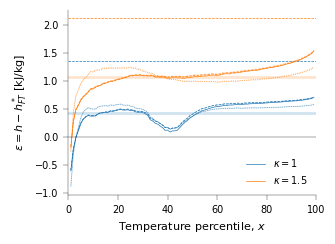

In [20]:
percentile_label = 'Temperature percentile, $x$'

save_epsilon_fig = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax.plot(quant_plot, np.average(mse_quant3[i, ind_surf] - mse_quant3[i, ind_ft], axis=0, weights=lat_weights),
            color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    for j, line_alpha in enumerate([0.5, 1]):
        ax.plot(quant_plot, np.average(epsilon_theory[i]+(1-j)*epsilon_theory_squared_term[i], axis=0, weights=lat_weights),
                color=default_colors[i], linestyle='--', alpha=line_alpha)
        ax.plot(quant_plot, np.average(epsilon_theory_simple[i]+(1-j)*epsilon_theory_simple_squared_term[i], axis=0, weights=lat_weights),
                color=default_colors[i], linestyle=':', alpha=line_alpha)
    ax.axhline(np.average(mse_mean[i, ind_surf] - mse_mean[i, ind_ft], axis=0, weights=lat_weights), color=default_colors[i], lw=2, alpha=0.2)
    ax.axhline(np.average(epsilon_theory_mean[i], axis=0, weights=lat_weights), color=default_colors[i], linestyle='--')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_ylabel('$\epsilon = h-h^*_{FT}$ [kJ/kg]')
ax.legend()
ax.set_xlim(0, 100)
if save_fig or save_epsilon_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/epsilon_theory_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### WTG Evaluation
In the theory, we assume weak temperature gradient . Below I consider the quantity $\mu(x) = h_{FT}^*(x) - \overline{h_{FT}^*}$ to see if this is valid.

Using the approximation $\kappa(x) = \frac{z_{FT}}{T_{FT}} \approx \overline{\kappa} + 0.5 \left(\frac{\Gamma(x)}{\overline{\Gamma}}-1\right)\overline{\Gamma}\overline{\kappa}^2$, we can obtain the approximation:
$\mu \approx \frac{g\overline{z}^2}{2\overline{T_{FT}}}(\Delta \Gamma_a(x) - \Delta \overline{\Gamma_a} + \Delta \Gamma_A) + (c_p + L_v \overline{\alpha} \overline{q^*} + g \frac{\overline{z}}{\overline{T_{FT}}})\Delta T_{FT}(x)$
where $\Delta \Gamma_A = \Gamma_a(x) - \overline{\Gamma_a}$.

This approximation is pretty good as shown by the dashed line below. I split it up into a lapse rate term (first on RHS), shown by the dot-dashed line and a WTG term (second on RHS), shown by the dotted line. Clearly, the deviation of $\mu$ from 0 is dominated by the WTG term.

Interestingly, if WTG was correct, $\Delta T_{FT}=0$ but $\mu \neq 0$. If the profile was also convective for all days, $\Delta \Gamma_a(x) = \Delta \overline{\Gamma} = 0$ (changes in surface temperature would cause this to vary), but we wouldn't have $\Delta \Gamma_A = 0$ so $\mu \neq 0$ still.


In [21]:
dev_lapse_ad = lapse_quant3 - lapse_adiabat_quant3              # diff of actual lapse from adiabat.
dev_lapse_ad_mean = np.expand_dims(lapse_mean - lapse_adiabat_mean, axis=-1)
dev_lapse_ad2 = lapse_adiabat_quant3 - np.expand_dims(lapse_adiabat_mean, axis=-1)       # diff of adiabat on day x from on mean
dev_temp_ft = temp_quant3[:, ind_ft] - np.expand_dims(temp_mean[:, ind_ft], axis=-1)

prefactor_mu_lapse = 0.5 * g * np.expand_dims(z_mean[:, ind_ft]/temp_mean[:, ind_ft] * z_mean[:, ind_ft], axis=-1) / 1000
mu_theory_lapse = prefactor_mu_lapse * (dev_lapse_ad - dev_lapse_ad_mean + dev_lapse_ad2)
prefactor_mu_wtg = (c_p + L_v * alpha_mean * q_ft_mean + g * np.expand_dims(z_mean[:, ind_ft]/temp_mean[:, ind_ft], axis=-1)) / 1000
mu_theory_wtg = prefactor_mu_wtg * dev_temp_ft
mu_theory = mu_theory_lapse + mu_theory_wtg

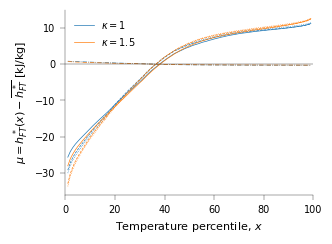

In [22]:
save_mu_fig = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax.plot(quant_plot, np.average(mse_quant3[i, ind_ft] - mse_mean[i, ind_ft][:, np.newaxis], axis=0, weights=lat_weights),
            color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax.plot(quant_plot, np.average(mu_theory[i], axis=0, weights=lat_weights),
            color=default_colors[i], linestyle='--')
    ax.plot(quant_plot, np.average(mu_theory_wtg[i], axis=0, weights=lat_weights),
            color=default_colors[i], linestyle=':')
    ax.plot(quant_plot, np.average(mu_theory_lapse[i], axis=0, weights=lat_weights),
            color=default_colors[i], linestyle='-.')
    
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_ylabel('$\mu = h^*_{FT}(x) - \overline{h^*_{FT}}$ [kJ/kg]')
ax.legend()
ax.set_xlim(0, 100)

if save_fig or save_mu_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mu_theory_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Surface MSE Distribution
We can combine the above equations for $\epsilon$ and $\mu$ to understand why at the surface, $h(x) \neq \overline{h}$ as we might expect if both WTG and convection were fully active.

$h(x) - \overline{h} = \epsilon(x) - \overline{\epsilon} + \mu(x)$

Using our simpler linear version of $\epsilon$, we can split this up into a lapse rate and WTG contribution:
$h(x) - \overline{h} \approx \left(c_p + L_v \overline{\alpha} \overline{q^*} + \frac{g\overline{z}}{2\overline{T_{FT}}}\right)\overline{z}(\Delta \Gamma_a(x) - \Delta \overline{\Gamma_a}) + \frac{g\overline{z}^2}{2\overline{T_{FT}}}\Delta \Gamma_A + (c_p + L_v \overline{\alpha} \overline{q^*} + g \frac{\overline{z}}{\overline{T_{FT}}})\Delta T_{FT}(x)$

It is clear that the lapse term dominates the variation for cold days and the WTG term dominates for hot days.

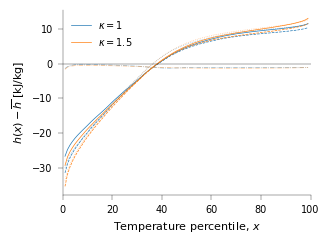

In [23]:
save_dev_h_surf_fig = True
# Choose which version of epsilon to use
# epsilon_theory_use = epsilon_theory
epsilon_theory_use = epsilon_theory_simple
# epsilon_theory_use = epsilon_theory_simple + epsilon_theory_simple_squared_term
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax.plot(quant_plot, np.average(mse_quant3[i, ind_surf] - mse_mean[i, ind_surf][:, np.newaxis], axis=0, weights=lat_weights),
            color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax.plot(quant_plot, np.average(epsilon_theory_use[i] - epsilon_theory_mean[i][:, np.newaxis] + mu_theory[i], axis=0, weights=lat_weights),
            color=default_colors[i], linestyle='--')
    ax.plot(quant_plot, np.average(mu_theory_wtg[i], axis=0, weights=lat_weights),
            color=default_colors[i], linestyle=':', alpha=0.5)
    ax.plot(quant_plot, np.average(epsilon_theory_use[i] - epsilon_theory_mean[i][:, np.newaxis] + mu_theory_lapse[i], 
                                   axis=0, weights=lat_weights), color=default_colors[i], linestyle='-.', alpha=0.5)
    
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_ylabel('$h(x) - \overline{h}$ [kJ/kg]')
ax.legend()
ax.set_xlim(0, 100)

if save_fig or save_dev_h_surf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/dev_h_surf_theory_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $\delta h(x)$ Contributions

Below, I look at how changes to WTG and lapse rate (CQE) contribute to why $\delta h(x) \neq \delta \overline{h}$. For low $x$, they seem to cancel each other out. But for high $x$, they seem to reinforce each other.

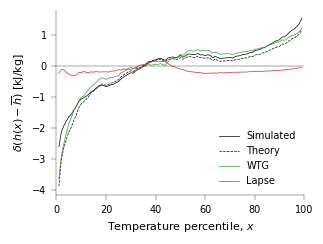

In [27]:
save_delta_h_surf_fig = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quant_plot, np.average(np.diff(mse_quant3[:, ind_surf] - mse_mean[:, ind_surf][:, :, np.newaxis], axis=0)[0], 
                               axis=0, weights=lat_weights), color='k', label='Simulated')
ax.plot(quant_plot, np.average(np.diff(epsilon_theory_use - epsilon_theory_mean[:, :, np.newaxis] + mu_theory, axis=0)[0], axis=0,
                               weights=lat_weights), color='k', linestyle='--', label='Theory')
ax.plot(quant_plot, np.average(np.diff(mu_theory_wtg, axis=0)[0], axis=0, weights=lat_weights),
        color=default_colors[2], label='WTG')
ax.plot(quant_plot, np.average(np.diff(epsilon_theory_use - epsilon_theory_mean[:, :, np.newaxis] + mu_theory_lapse, axis=0)[0], 
                               axis=0, weights=lat_weights), color=default_colors[3], label='Lapse')
ax.set_ylabel('$\delta (h(x) - \overline{h})$ [kJ/kg]')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.legend()
ax.set_xlim(0, 100)

if save_fig or save_delta_h_surf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/delta_h_surf_theory_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 100.0)

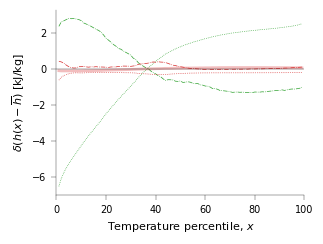

In [25]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quant_plot, np.average(np.diff(prefactor_mu_wtg, axis=0)[0] * dev_temp_ft[0], axis=0, weights=lat_weights), 
        color=default_colors[2], linestyle=':')
ax.plot(quant_plot, np.average(prefactor_mu_wtg[0] * np.diff(dev_temp_ft,axis=0).squeeze(), axis=0, weights=lat_weights), 
        color=default_colors[2], linestyle='-.')
ax.plot(quant_plot, np.average(np.diff(prefactor_epsilon_simple + prefactor_mu_lapse, axis=0)[0] * (dev_lapse_ad-dev_lapse_ad_mean)[0],
                               axis=0, weights=lat_weights), color=default_colors[3], linestyle=':')
ax.plot(quant_plot, np.average((prefactor_epsilon_simple + prefactor_mu_lapse)[0] * np.diff(dev_lapse_ad-dev_lapse_ad_mean,axis=0).squeeze(), 
                               axis=0, weights=lat_weights), color=default_colors[3], linestyle='-.')
ax.plot(quant_plot, np.average(np.diff(prefactor_mu_lapse * dev_lapse_ad2, axis=0)[0], 
                               axis=0, weights=lat_weights), color=default_colors[3], linestyle='-', alpha=0.3, lw=2)
ax.set_ylabel('$\delta (h(x) - \overline{h})$ [kJ/kg]')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.legend()
ax.set_xlim(0, 100)

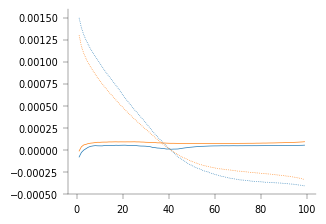

In [26]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax.plot(quant_plot, np.average(dev_lapse_ad[i], axis=0, weights=lat_weights),
            color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax.plot(quant_plot, np.average(dev_lapse_ad2[i], axis=0, weights=lat_weights),
            color=default_colors[i], label=f'$\kappa={tau_lw[i]}$', linestyle=':')